# Create dataset and load data loader

In [1]:
import os
import pandas as pd
from torch.utils.data import Dataset
import torch, torchvision
from torchvision.io import read_image
from sklearn import preprocessing
from random import seed
from random import sample
import matplotlib.pyplot as plt
import numpy as np

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.df = pd.read_csv(annotations_file)
        if target_transform:
            self.img_labels = target_transform.fit_transform(self.df['label'])
        else:
            self.img_labels = self.df['label']
        self.img_fname = self.df['image']
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_fname.loc[idx])
        image = read_image(img_path)
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label
        
    def get_class_imbalance(self):
        print(self.df['label'].value_counts()/len(self.df))
    
    def plot_random_img_per_class(self, num_imgs=1):
        for l in pd.unique(self.df['label']):
            seq = self.df[self.df['label']==l].index.tolist()#a sequence of sample index with a given label/class
            idxs = sample(seq,num_imgs)
            for i in idxs:
                image, label = self.__getitem__(i)
                image = image.permute(1,2,0)
                plt.imshow(image, cmap="gray")
                plt.show()
                print(l)

/data/home/acw607/stacking/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torchvision.transforms import ToTensor, Lambda
annotations_file, img_dir = 'gt_df_simple.csv', 'gopro_videos/batch_1/'
full_dataset = CustomImageDataset(annotations_file, img_dir, target_transform=None)

In [3]:
full_dataset.get_class_imbalance()

Safe      0.838235
Unsafe    0.161765
Name: label, dtype: float64


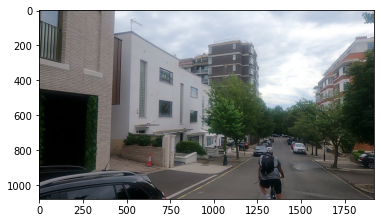

Safe


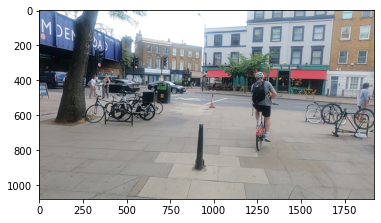

Safe


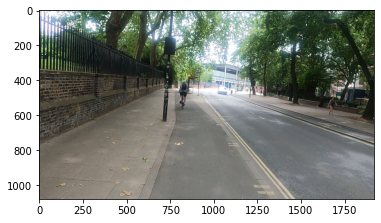

Safe


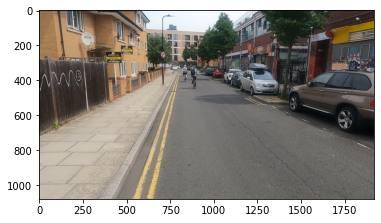

Safe


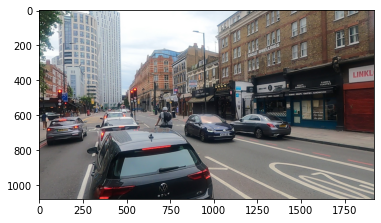

Safe


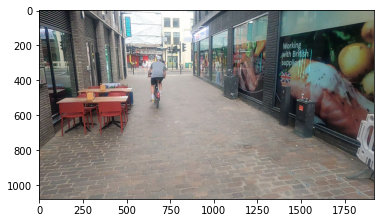

Unsafe


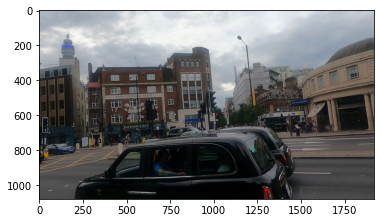

Unsafe


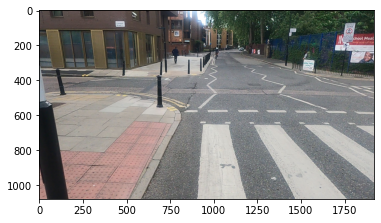

Unsafe


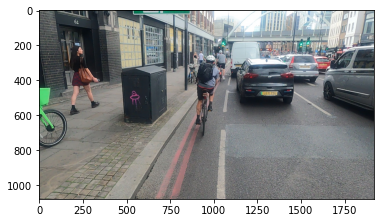

Unsafe


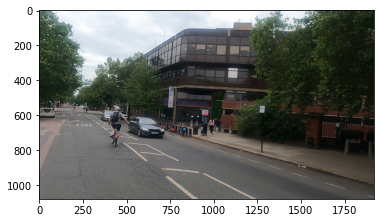

Unsafe


In [4]:
full_dataset.plot_random_img_per_class(num_imgs=5)

# Apply image transformation and create dataloader

# (1) check label encoder

In [5]:
le = preprocessing.LabelEncoder()
df = pd.read_csv(annotations_file)
trans = le.fit_transform(df['label'])
old = le.inverse_transform(trans)
safe_index_list = df[df['label']=='Safe'].index
unsafe_index_list = df[df['label']=='Unsafe'].index
all_lists = [safe_index_list[0], unsafe_index_list[0]]
for j in all_lists:
    print(old[j], trans[j])

Safe 0
Unsafe 1


# (2) Transform images to VGG input shape and style

In [6]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# (3) get transformed train, test dataset

In [7]:
full_dataset = CustomImageDataset(annotations_file, img_dir, transform=trans, target_transform=le)
train_ratio = 0.8
train_size = int(train_ratio * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# Augmentation on only train set to enlarge dataset
source: https://discuss.pytorch.org/t/imbalanced-class-augmentation-problem/144135

In [8]:
# First Aug
print("Augmentating...")
aug_dataset1 = []
first_transform =  torchvision.transforms.RandomPerspective(distortion_scale=0.6, p=1.0)

for i in range(0,len(train_dataset)):
  transf_img = first_transform(train_dataset[i][0])
  transf_tuple = (transf_img , train_dataset[i][1])
  aug_dataset1.append(transf_tuple)


# Second Aug
print("Augmentating...")
aug_dataset2 = []
second_transform = torchvision.transforms.RandomHorizontalFlip(p=0.5)

for i in range(0,len(train_dataset)):
  transf_img = second_transform(train_dataset[i][0])
  transf_tuple = (transf_img , train_dataset[i][1])
  aug_dataset2.append(transf_tuple)

train_dataset = torch.utils.data.ConcatDataset([train_dataset,aug_dataset1])
train_dataset = torch.utils.data.ConcatDataset([train_dataset,aug_dataset2])


Augmentating...
Augmentating...


# Resampling on only train set
source: https://discuss.pytorch.org/t/how-to-handle-imbalanced-classes/11264/2?u=ptrblck

In [9]:
def get_sampler(target):
  class_sample_count = np.unique(target, return_counts=True)[1]
  weight = 1. / class_sample_count
  samples_weight = weight[target]

  samples_weight = torch.from_numpy(samples_weight)
  samples_weigth = samples_weight.double()
  sampler = torch.utils.data.WeightedRandomSampler(samples_weight, len(samples_weight))
  
  return sampler


train_targets = []
for i in range(0,len(train_dataset)):
  train_targets.append(train_dataset[i][1])


train_sampler = get_sampler(train_targets)


In [10]:
b_size = 64

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=b_size,
    num_workers=0,
    sampler = train_sampler
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=b_size,
    num_workers=0
)

In [11]:
def check_dataloader_imbalance(dataloader):
    unsafe_count = 0
    total = 0
    for batch, (data, target) in enumerate(dataloader, 1):
        unsafe_count+=sum(target)
        total+=len(target)
    return unsafe_count/total

In [12]:
check_dataloader_imbalance(test_loader)

tensor(0.1800)

In [13]:
check_dataloader_imbalance(train_loader)

tensor(0.4866)

# Train a pre-trained VGG model

In [14]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

num_classes = len(full_dataset.df['label'].unique())-1
model = models.vgg16(pretrained=True)
model.classifier[-1] = nn.Linear(in_features=4096, out_features=num_classes)

# Apply f1 calculation on validation process

In [15]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_precision_recall_F1(preds, targets, probs): 
    """
    1. The func uses sklearn library
    2. The func does not support confidence threshold feature, i.e, we can't calculate scores by adjusting a confidence threshold.
    3. The func treats each class the same, i.e, it is a balanced score function for producing average performance of all classes => specifically deal with imbalanced data
    
    
    """
    p = precision_score(targets, preds, average='macro')
    r = recall_score(targets, preds, average='macro')
    f1 = f1_score(targets, preds, average='macro')
    targets,probs= targets.squeeze(),probs.squeeze()
    auc = roc_auc_score(targets,probs)
    print('precision: {:.2f}'.format(p))
    print('recall: {:.2f}'.format(r))
    print('F1: {:.2f}'.format(f1))
    print('AUC: {:.2f}'.format(auc))
    return "{:.2f}".format(p), "{:.2f}".format(r), "{:.2f}".format(f1),  "{:.2f}".format(auc)

In [16]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    train_losses = 0
    train_corrects = 0
    counter = 0
    for batch, (data, target) in enumerate(train_loader, 1):
        counter+=1
        data = data.to(device)
        target = torch.unsqueeze(target,1)
        target = target.float()
        target = target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        train_losses+=loss.item()
        # calculate the acc
        pred = torch.sigmoid(output.data)
        pred = torch.round(pred)
        train_corrects += (pred == target).sum().item()
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
      
    # loss and accuracy for the complete epoch
    epoch_loss = train_losses/ counter
    epoch_acc = 100. * (train_corrects / len(train_loader.dataset))

    return epoch_loss, epoch_acc


def validate(model, val_loader, criterion, device):
    model.eval()
    val_losses = 0
    val_corrects = 0
    counter = 0
    val_probs = []
    val_preds = []
    val_gts = []
    with torch.no_grad():
        for data, target in val_loader:
            counter += 1
            data = data.to(device)
            target = torch.unsqueeze(target,1)
            target = target.float()
            target = target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            val_losses+=loss.item()  
            # calculate the accuracy
            probs = torch.sigmoid(output.data)
            pred = torch.round(probs)
            val_corrects += (pred == target).sum().item()
            val_probs.append(probs.cpu().detach().numpy())
            val_preds.append(pred.cpu().detach().numpy())
            val_gts.append(target.cpu().detach().numpy())
            
    val_preds, val_gts, val_probs = np.concatenate(val_preds, axis=0), np.concatenate(val_gts, axis=0), np.concatenate(val_probs, axis=0)
    _,_,f1,_ = get_precision_recall_F1(preds=val_preds, targets=val_gts, probs=val_probs)
    
    # loss and accuracy for the complete epoch
    epoch_loss = val_losses/ counter
    epoch_acc = 100. * (val_corrects / len(val_loader.dataset))

    return epoch_loss, epoch_acc, float(f1)


In [17]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [18]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
model.to(device)
print(device)

cuda


[INFO]: Epoch 2 of 20
precision: 0.55
recall: 0.58
F1: 0.50
AUC: 0.62
Training loss: 0.658, training acc: 58.863
Validation loss: 0.698, validation acc: 56.667

Best validation f1: 0.5

Saving best model for epoch: 2

--------------------------------------------------
[INFO]: Epoch 3 of 20
precision: 0.56
recall: 0.58
F1: 0.56
AUC: 0.66
Training loss: 0.543, training acc: 71.962
Validation loss: 0.535, validation acc: 70.667

Best validation f1: 0.56

Saving best model for epoch: 3

--------------------------------------------------
[INFO]: Epoch 4 of 20
precision: 0.58
recall: 0.58
F1: 0.58
AUC: 0.66
Training loss: 0.401, training acc: 82.497
Validation loss: 0.516, validation acc: 76.000

Best validation f1: 0.58

Saving best model for epoch: 4

--------------------------------------------------
[INFO]: Epoch 5 of 20
precision: 0.51
recall: 0.50
F1: 0.49
AUC: 0.64
Training loss: 0.291, training acc: 87.179
Validation loss: 0.600, validation acc: 78.000
-------------------------------

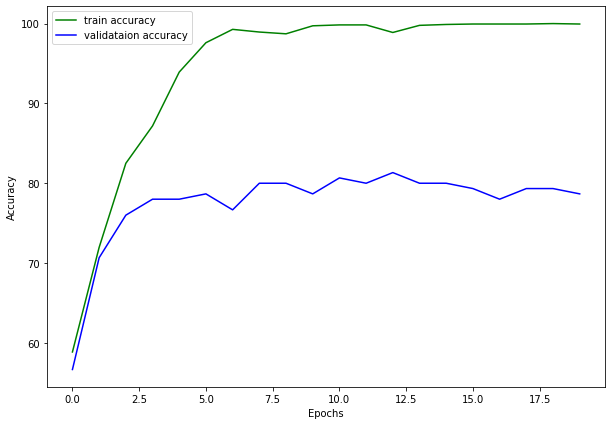

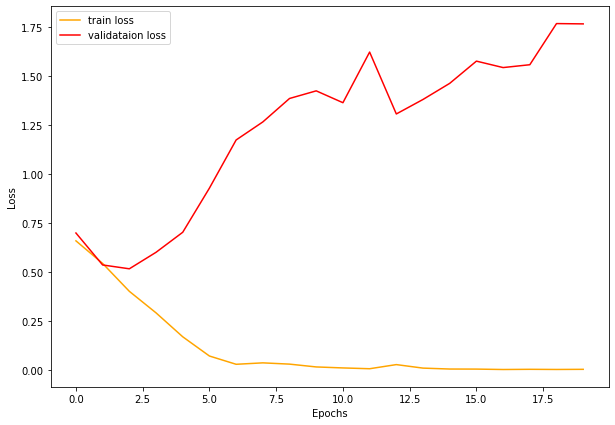

In [19]:
import utils.model_saver as MS
epochs = 20

train_loss, valid_loss = [], []
train_acc, valid_acc = [], []

save_model_folder = 'training_results/' 
if not os.path.exists(save_model_folder):
    os.mkdir(save_model_folder)
    
save_best_model_f1 = MS.SaveBestModel_by_f1()
model_name = 'cnn_categorical'

for epoch in range(1, epochs + 1):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_loader, 
                                            optimizer, criterion, device)
    valid_epoch_loss, valid_epoch_acc, f1 = validate(model, test_loader,  
                                                criterion, device)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}")
    print(f"Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}")
    save_best_model_f1(f1, epoch, model, model_name, optimizer, criterion, save_model_folder)
    print('-'*50)

# save the trained model weights for a final time
MS.save_model(epochs, model, model_name, optimizer, criterion, save_model_folder)
# save the loss and accuracy plots
MS.save_plots(model_name, train_acc, valid_acc, train_loss, valid_loss, save_model_folder)
print('TRAINING COMPLETE')

# Load model 

In [20]:
def load_cnn(model_folder, model):
    model_path = model_folder+'best_cnn_categorical_model_byf1.pth'
    model= model.to(device)
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

In [21]:
model_folder = 'training_results/'
model =  load_cnn(model_folder, model)

# Predict test set accuracy

In [24]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
model.eval()
test_gts = []
preds = []
label_list =[]
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        label_list.append(labels)
        labels = torch.unsqueeze(labels,1)
        test_gts.append(labels)
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        predicted = torch.unsqueeze(predicted,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predicted = predicted.cpu().detach().numpy()
        preds.append(predicted)

print(f'Accuracy of the network on the test images: {100 * correct // total} %')

Accuracy of the network on the test images: 82 %


# Check confusion matrix on test set

In [25]:
test_gts = np.concatenate(test_gts,axis=0)
preds= np.concatenate(preds,axis=0)

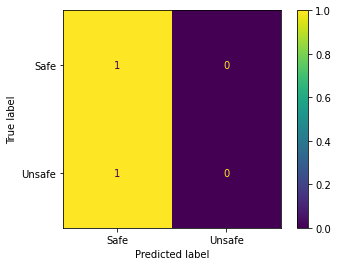

In [26]:
from sklearn import metrics
import matplotlib.pyplot as plt

confusion_matrix = metrics.confusion_matrix(test_gts,preds, normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['Safe', 'Unsafe'])
cm_display.plot()
plt.show()